<a href="https://colab.research.google.com/github/Unknown15082/Machine-Learning/blob/main/NotebookDay2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
from keras.datasets import mnist
from matplotlib import pyplot as plt

In [62]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

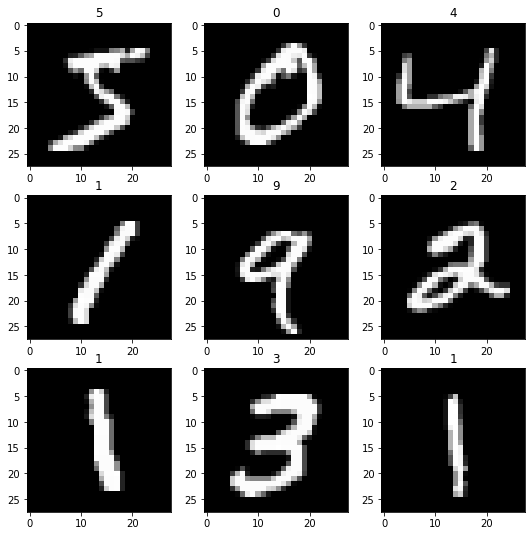

In [63]:
fig, axs = plt.subplots(3, 3, figsize = (9, 9))

for i in range(9):
    row = i // 3
    col = i % 3

    axs[row][col].imshow(train_x[i], cmap = "gray")
    axs[row][col].set_title(train_y[i])

plt.show()

In [64]:
train_x = train_x / 255.0
test_x = test_x / 255.0

# resize [0, 255] => [0, 1] --> less bias

In [65]:
from sklearn.model_selection import train_test_split

In [66]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.01, random_state = 42)
# 42 -> seed

In [67]:
import torch

In [68]:
class Data(torch.utils.data.Dataset):
    def __init__(self, data, label):
        self.x = data
        self.y = label

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [69]:
train, val = Data(train_x, train_y), Data(val_x, val_y)

In [70]:
train_dataloader = torch.utils.data.DataLoader(train, batch_size = 32)
val_dataloader = torch.utils.data.DataLoader(val, batch_size = 32)

In [71]:
train_x[0].shape # (28, 28)
# 28 * 28 => 784

(28, 28)

In [72]:
from torch import nn

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()

        self.linear1 = nn.Linear(784, 32)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(32, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [73]:
x = train_x[0]
x = torch.flatten(torch.tensor(x))

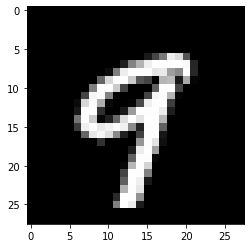

In [74]:
plt.imshow(train_x[0], cmap = "gray")
plt.show()

In [75]:
model = SimpleModel()

use_cuda = torch.cuda.is_available()

device = torch.device('cuda' if use_cuda else 'cpu')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model = model.to(device)
criterion = criterion.to(device)

In [82]:
from tqdm import tqdm

min_val_loss = 10**18
for epoch in range(6):
    total_loss_train = 0
    total_accuracy_train = 0

    for x, y in tqdm(train_dataloader):
        x = x.to(device)
        y = y.to(device)

        output = model(x.float())
        batch_loss = criterion(output, y)
        total_loss_train += batch_loss

        acc = (output.argmax(dim = 1) == y).sum().item()
        total_accuracy_train += acc

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    total_loss_val = 0
    total_accuracy_val = 0

    with torch.no_grad():
        for x, y in tqdm(val_dataloader):
            x = x.to(device)
            y = y.to(device)

            output = model(x.float())
            batch_loss = criterion(output, y)
            total_loss_val += batch_loss.item()

            acc = (output.argmax(dim = 1) == y).sum().item()
            total_accuracy_val += acc

    print(
        f"Epoch {epoch + 1} | Train Loss {total_loss_train / len(train) :.3f}\
         | Train Accuracy {total_accuracy_train / len(train) :.3f}\
         | Val Loss: {total_loss_val / len(val) :.3f}\
         | Val Accuracy: {total_accuracy_val / len(val) :.3f}"
    )

    if min_val_loss > total_loss_val / len(val):
        min_val_loss = total_loss_val / len(val)
        torch.save(model.state_dict(), "simplemodel.pt")
        print("Saved (Improve total loss)")

100%|██████████| 19/19 [00:00<00:00, 1256.02it/s]


Epoch 1 | Train Loss 0.003         | Train Accuracy 0.973         | Val Loss: 0.004         | Val Accuracy: 0.958
Saved (Improve total loss)


100%|██████████| 19/19 [00:00<00:00, 1285.83it/s]


Epoch 2 | Train Loss 0.003         | Train Accuracy 0.973         | Val Loss: 0.004         | Val Accuracy: 0.958


100%|██████████| 19/19 [00:00<00:00, 1184.62it/s]


Epoch 3 | Train Loss 0.003         | Train Accuracy 0.973         | Val Loss: 0.004         | Val Accuracy: 0.958


100%|██████████| 19/19 [00:00<00:00, 1168.72it/s]


Epoch 4 | Train Loss 0.003         | Train Accuracy 0.973         | Val Loss: 0.004         | Val Accuracy: 0.958


100%|██████████| 19/19 [00:00<00:00, 888.67it/s]


Epoch 5 | Train Loss 0.003         | Train Accuracy 0.973         | Val Loss: 0.004         | Val Accuracy: 0.958


100%|██████████| 19/19 [00:00<00:00, 1278.40it/s]

Epoch 6 | Train Loss 0.003         | Train Accuracy 0.973         | Val Loss: 0.004         | Val Accuracy: 0.958


In [77]:
model = SimpleModel()

model = model.to(device)

model.load_state_dict(torch.load("/content/simplemodel.pt"))

<All keys matched successfully>

In [78]:
test_x = torch.tensor(test_x).to(device)
test_y = torch.tensor(test_y).to(device)

In [79]:
(model(test_x.float()).argmax(dim = 1) == test_y).sum().item() / test_y.shape[0]

0.9634

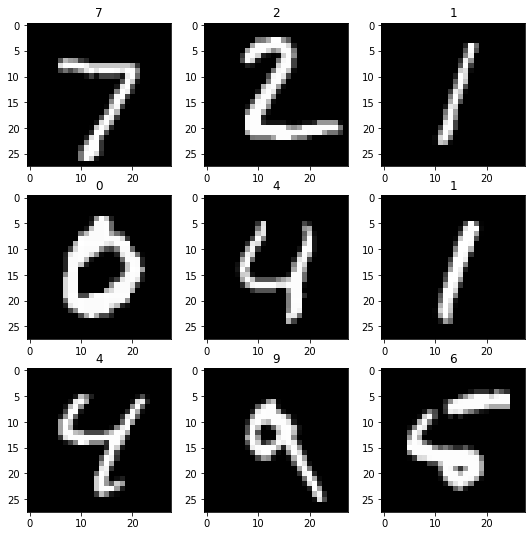

In [80]:
fig, axs = plt.subplots(3, 3, figsize = (9, 9))
for i in range(9):
    row = i // 3
    col = i % 3

    axs[row][col].imshow(test_x[i].cpu(), cmap = "gray")
    axs[row][col].set_title(model(test_x[i:i+1].float()).argmax(dim = 1)[0].item())

plt.show()